이제 우리의 데이터셋을 수동으로 모델링하는 과정을 자동화하여 재현해 보겠습니다. 작업 계획은 다음과 같았습니다:

1. 시계열을 생성하는 과정에 대한 귀중한 통찰을 추출하기 위해 데이터셋에서 EDA를 수행합니다 **(완료)**.
2. 벤치마킹을 위한 기준 모델(외생 변수 없는 단변량 모델)을 구축합니다 **(완료)**.
3. 최적의 성능을 확인하기 위해 모든 외생 변수를 포함한 단변량 모델을 구축합니다 **(완료)**.
4. 외생 변수가 있는 모델을 평가하고 잠재적인 문제를 논의합니다 **(완료)**.
5. 위에서 확인한 문제를 해결합니다 **(완료)**.
6. 최적의 모델로 미래 예측을 수행합니다 **(완료)**.
7. 자동화된 시계열 모델링(AutoML)으로 흐름을 복제합니다 **(이 노트북에서 다룸)**.

In [1]:
# 중요한 로깅만 활성화하기 (선택 사항)
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [2]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret
    what_is_installed()


System:
    python: 3.8.13 (default, Oct 19 2022, 17:52:09)  [Clang 12.0.0 ]
executable: /Users/teddy/miniconda/envs/py38/bin/python
   machine: macOS-13.4.1-arm64-arm-64bit

PyCaret required dependencies:
                 pip: 22.2.2
          setuptools: 63.4.1
             pycaret: 3.0.4
             IPython: 8.5.0
          ipywidgets: 8.0.2
                tqdm: 4.64.1
               numpy: 1.23.4
              pandas: 1.5.1
              jinja2: 3.1.2
               scipy: 1.10.0
              joblib: 1.2.0
             sklearn: 1.2.1
                pyod: 1.1.0
            imblearn: 0.11.0
   category_encoders: 2.6.1
            lightgbm: 3.3.5
               numba: 0.57.1
            requests: 2.28.1
          matplotlib: 3.6.0
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.13.0
    plotly-resampler: Not installed
             kaleido: 0.2.1
           schemdraw: 0.15
         statsmodels: 0.14.0
              sktime: 0.20.0
               tbats:

In [3]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [4]:
# 노트북 전체에 대한 전역 그림 설정 ----
# 사용 중인 환경에 따라 jupyter notebook, jupyter lab, Google Colab을 사용하는 경우 renderer를 적절하게 설정해야 합니다.
# 참고: 여기서는 노트북 저장 크기를 줄이기 위해 정적 렌더러로 설정합니다.
global_fig_settings = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

In [5]:
data = get_data("airquality", verbose=False)

# 데모 목적으로 데이터 제한하기
data = data.iloc[-720:]
data["index"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.drop(columns=["Date", "Time"], inplace=True)
data.replace(-200, np.nan, inplace=True)
data.set_index("index", inplace=True)

target = "CO(GT)"
exog_vars = ['NOx(GT)', 'PT08.S3(NOx)', 'RH']
include = [target] + exog_vars
data = data[include]
data.head()

,CO(GT),NOx(GT),PT08.S3(NOx),RH
index,,,,
2005-03-05 15:00:00,1.5,180.0,820.0,28.3
2005-03-05 16:00:00,1.8,255.0,751.0,29.7
2005-03-05 17:00:00,2.0,251.0,721.0,38.7
2005-03-05 18:00:00,1.9,258.0,695.0,56.3
2005-03-05 19:00:00,2.5,344.0,654.0,57.9


# 단계 7: AutoML을 사용한 자동화된 시계열 모델링

In [6]:
FH=48
metric = "mase"
exclude = ["auto_arima", "bats", "tbats", "lar_cds_dt", "par_cds_dt"]

# 단계 7A: 외생 변수를 사용한 단일 변수 AutoML 및 외생 변수 없이 AutoML

In [7]:
exp_auto = TSForecastingExperiment()

# enforce_exogenous=False --> 모델이 지원하는 경우 다변량 예측을 사용하고, 그렇지 않은 경우 단일 변수 예측을 사용합니다.
exp_auto.setup(
    data=data, target=target, fh=FH, enforce_exogenous=False,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(720, 4)"
5,Transformed data shape,"(720, 4)"
6,Transformed train set shape,"(672, 4)"
7,Transformed test set shape,"(48, 4)"
8,Rows with missing values,3.8%
9,Fold Generator,ExpandingWindowSplitter


In [8]:
# 사용 가능한 모델 확인하기 ----
# exp_auto_noexo.models()

In [9]:
# Prophet과 같은 느린 모델을 포함하되, 특정 모델을 제외합니다.
# exp_auto_noexo.exclude_models(['model_name_1', 'model_name_2'])
# exp_auto_noexo.include_models(turbo=False)
best = exp_auto.compare_models(sort=metric, turbo=False, exclude=exclude)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.2509,0.2302,0.1810,0.2449,0.1443,0.1523,0.8499,0.2633
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.8609,0.8199,0.6211,0.8730,0.4675,0.4450,-0.7053,0.2500
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.8647,0.8218,0.6238,0.8750,0.4714,0.4491,-0.7106,0.2467
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.8651,0.8220,0.6240,0.8752,0.4718,0.4494,-0.7111,0.5000
snaive,Seasonal Naive Forecaster,0.9672,0.9659,0.6972,1.0275,0.4645,0.3643,-1.8616,0.0300
catboost_cds_dt,CatBoost Regressor w/ Cond. Deseasonalize & Detrending,0.9836,0.8231,0.7101,0.8768,0.5714,0.5894,-0.5004,1.2700
theta,Theta Forecaster,0.9871,0.8962,0.7146,0.9574,0.4639,0.4412,-0.2349,0.0167
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.9948,0.9519,0.7181,1.0130,0.5099,0.3702,-1.7375,0.2567
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.0081,0.9598,0.7275,1.0213,0.5178,0.3741,-1.8353,0.2433
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.0081,0.9598,0.7275,1.0213,0.5178,0.3741,-1.8354,0.2533


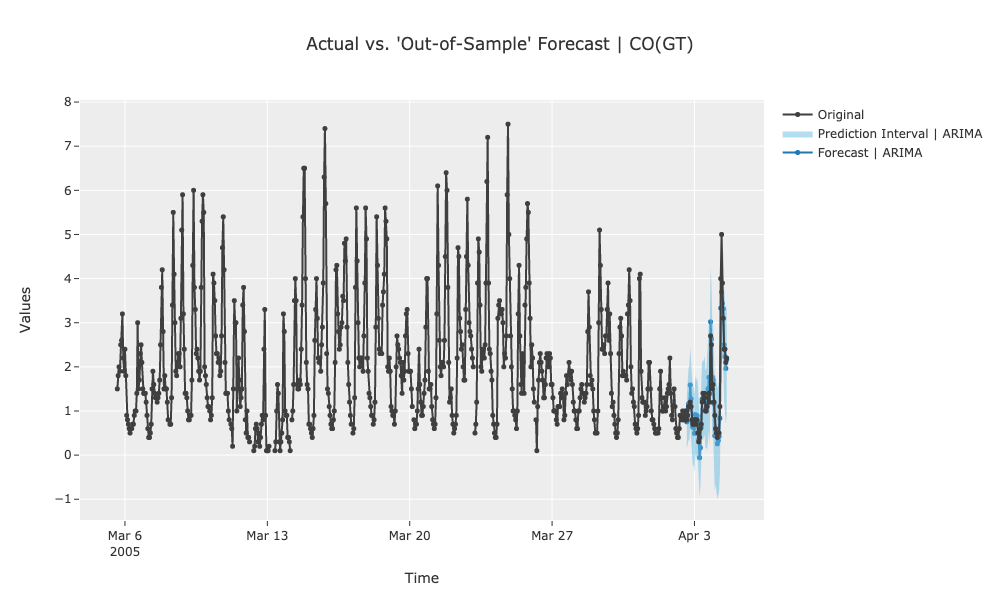

In [10]:
exp_auto.plot_model(best)

In [11]:
final_auto_model = exp_auto.finalize_model(best)

In [12]:
def safe_predict(exp, model):
    """데모를 위한 예측 래퍼 함수."""
    try:
        future_preds = exp.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        print(f"미래 예측을 위해 {len(exo_vars)}개의 외생 변수 (X)가 필요합니다:\n{exo_vars}")


        exog_exps = []
        exog_models = []
        for exog_var in exog_vars:
            exog_exp = TSForecastingExperiment()
            exog_exp.setup(
                data=data[exog_var], fh=FH,
                numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
                fig_kwargs=global_fig_settings, session_id=42
            )

            # 사용자는 미래 외생 변수를 모델링하는 방법을 사용자 정의할 수 있습니다.
            # 예를 들어, 더 많은 단계와 모델을 추가하여 더 나은 모델을 얻을 수 있지만,
            # 모델링 시간이 늘어날 수 있습니다.
            best = exog_exp.compare_models(
                sort=metric, include=["arima", "ets", "exp_smooth", "theta", "lightgbm_cds_dt",]
            )
            final_exog_model = exog_exp.finalize_model(best)

            exog_exps.append(exog_exp)
            exog_models.append(final_exog_model)

        # 단계 2: 외생 변수에 대한 미래 예측 얻기 ----
        future_exog = [
            exog_exp.predict_model(exog_model)
            for exog_exp, exog_model in zip(exog_exps, exog_models)
        ]
        future_exog = pd.concat(future_exog, axis=1)
        future_exog.columns = exog_vars

        future_preds = exp.predict_model(model, X=future_exog)

    return future_preds

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
미래 예측을 위해 3개의 외생 변수 (X)가 필요합니다:
['NOx(GT)', 'PT08.S3(NOx)', 'RH']


,Description,Value
0,session_id,42
1,Target,NOx(GT)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.8%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.8406,0.9158,87.3689,133.0642,0.4273,0.3443,-1.3072,0.0800
theta,Theta Forecaster,1.0279,0.9437,107.4621,137.6886,0.5192,0.4990,-0.4072,0.0167
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.2021,1.1033,124.6215,160.1069,0.6995,0.5078,-2.5717,0.2333
exp_smooth,Exponential Smoothing,1.3411,1.2436,140.4939,181.3844,0.6563,0.9870,-2.2589,0.0533
ets,ETS,1.6539,1.5584,171.8478,226.4416,0.9317,0.5562,-4.3683,0.2367


,Description,Value
0,session_id,42
1,Target,PT08.S3(NOx)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.1%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,1.0938,1.1129,111.2510,146.6531,0.1591,0.1422,0.1075,0.0500
ets,ETS,1.3617,1.3130,138.5913,173.1125,0.1904,0.1875,-0.2074,0.1133
theta,Theta Forecaster,1.3716,1.3079,139.5929,172.4272,0.1909,0.1878,-0.1963,0.0200
arima,ARIMA,1.3929,1.3245,141.6775,174.6211,0.1792,0.1953,-0.3985,0.1167
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.6778,1.5491,170.7442,204.2588,0.2197,0.2541,-0.7666,0.2400


,Description,Value
0,session_id,42
1,Target,RH
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.1%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
theta,Theta Forecaster,1.6218,1.4765,11.3750,13.1578,0.2481,0.2286,-0.0585,0.0167
arima,ARIMA,1.8001,1.6165,12.6310,14.4108,0.2548,0.2523,-0.2695,0.0333
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,2.7797,2.6115,19.4667,23.2519,0.5241,0.3609,-4.8711,0.1067
exp_smooth,Exponential Smoothing,5.2972,4.7592,37.2425,42.4920,0.7188,0.9298,-10.5261,0.0467
ets,ETS,5.3233,4.7812,37.4251,42.6863,0.7227,0.9349,-10.5908,0.0333


<AxesSubplot: >

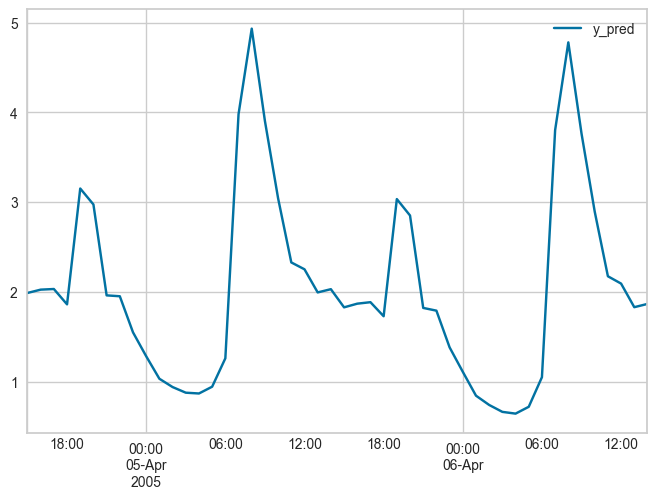

In [13]:
future_preds = safe_predict(exp_auto, final_auto_model)
future_preds.plot()